In [1]:
import numpy as np
import onsager.crystal as crystal
from states import *
from representations import *
import matplotlib.pyplot as plt
from scipy.constants import physical_constants
from Onsager_calc_db import BareDumbbell
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
kB = physical_constants['Boltzmann constant in eV/K'][0]
a0 = 0.28553
Fe = crystal.Crystal.BCC(a0, "Fe")
print(Fe)

#Lattice:
  a1 = [-0.142765  0.142765  0.142765]
  a2 = [ 0.142765 -0.142765  0.142765]
  a3 = [ 0.142765  0.142765 -0.142765]
#Basis:
  (Fe) 0.0 = [0. 0. 0.]


In [3]:
famp0 = [np.array([1.,1.,0.])/np.sqrt(2)*0.126]
family = [famp0]
pdbcontainer = dbStates(Fe,0,family)
jset,jind = pdbcontainer.jumpnetwork(0.25,0.01,0.01)
print(len(jind))

20


In [4]:
#Now extract the required jumps
#We remove the on-site rotations and then consider only the nearest neighbor jumps
#We assume that there is the same transition state for all the final orientations of the dumbell.
dx = np.array([0.5,0.5,0.5])*a0-np.array([0.0,0.0,0.0])*a0
mod_dx=np.sqrt(np.dot(dx,dx))
jsetnew=[]
jindnew=[]
for i,jl in enumerate(jind):
    dx = jl[0][2]
    if np.allclose(np.dot(dx,dx),mod_dx**2,atol=1e-8):
        jsetnew.append(jset[i])
        jindnew.append(jind[i])
print(len(jindnew))
print(mod_dx)

17
0.24727623354257078


In [5]:
diffuser = BareDumbbell(pdbcontainer, jindnew)
Dconv = 1e-2
vu0 = 10*Dconv
#Dconv and vu0 are the same as the Fe-C example in Onsager. We Note that our lengths are also in nanometers.
Etrans = 0.33

#Next we make the thermodict.
FeDbthermodict = {'pre': np.ones(len(pdbcontainer.symorlist)), 'ene': np.zeros(len(pdbcontainer.symorlist)),
                 'preT': vu0*np.ones(len(jindnew)),
                 'eneT': Etrans*np.ones(len(jindnew))}

In [6]:
#Next, we calculate the bare dumbbell diffusivities over a range of temperatures with unfiltered jumps.
Trange = np.linspace(300, 1200, 91)
Dlist=[]
for T in Trange:
    beta = 1./(kB*T)
    D = diffuser.diffusivity(FeDbthermodict['pre'], beta*FeDbthermodict['ene'], 
                             FeDbthermodict['preT'], beta*FeDbthermodict['eneT'])
    Dlist.append(D[0][0])

In [7]:
#Next, we calculated total squared displacement of atoms to filter out the Johnson jumps
def calc_sq_disp(jump,crys,chem):
    R1i = crys.unit2cart(jump.state1.R,crys.basis[chem][jump.state1.i])+(jump.c1/2.)*jump.state1.o
    R2i = crys.unit2cart(jump.state1.R,crys.basis[chem][jump.state1.i])-(jump.c1/2.)*jump.state1.o
    R3i = crys.unit2cart(jump.state2.R,crys.basis[chem][jump.state2.i])
    R1f = crys.unit2cart(jump.state2.R,crys.basis[chem][jump.state2.i])+(jump.c2/2.)*jump.state2.o
    R2f = crys.unit2cart(jump.state1.R,crys.basis[chem][jump.state1.i])
    R3f = crys.unit2cart(jump.state2.R,crys.basis[chem][jump.state2.i])-(jump.c2/2.)*jump.state2.o
    
    dx1 = R1f-R1i
    dx2 = R2f-R2i
    dx3 = R3f-R3i
    
#     print(R1i,R2i,R3i)
#     print(R1f,R2f,R3f)
    
    return np.dot(dx1,dx1)+np.dot(dx2,dx2)+np.dot(dx3,dx3)    

In [8]:
#The Johnson jump has the minimum squated displacement
idxmin = 0
for i,jl in enumerate(jsetnew):
    dsp = calc_sq_disp(jl[0],Fe,0)
    if dsp < calc_sq_disp(jsetnew[idxmin][0],Fe,0):
        idxmin=i
print(idxmin)

16


In [9]:
#See which orientations need to be searched for.
for pair in pdbcontainer.iorlist:
    print(pair)

(0, array([-0.08909545,  0.        ,  0.08909545]))
(0, array([ 0.        , -0.08909545, -0.08909545]))
(0, array([-0.08909545, -0.08909545,  0.        ]))
(0, array([ 0.        , -0.08909545,  0.08909545]))
(0, array([0.08909545, 0.        , 0.08909545]))
(0, array([-0.08909545,  0.08909545,  0.        ]))


In [10]:
#See if the Johnson jump is in this list
johnsonjumps=[]
for j in jsetnew[idxmin]:
    if np.allclose(j.state1.o,np.array([-0.08909545, -0.08909545,  0.])):
        if np.allclose(j.state2.o,np.array([0.        , -0.08909545, -0.08909545])):
            print(j)
            johnsonjumps.append(j)
                   

Jump object:
Initial state:
	dumbbell :basis index = 0, lattice vector = [0 0 0], orientation = [-0.08909545 -0.08909545  0.        ]
Final state:
	dumbbell :basis index = 0, lattice vector = [-1 -1 -1], orientation = [ 0.         -0.08909545 -0.08909545]
Jumping from c = 1 to c= -1

Jump object:
Initial state:
	dumbbell :basis index = 0, lattice vector = [0 0 0], orientation = [-0.08909545 -0.08909545  0.        ]
Final state:
	dumbbell :basis index = 0, lattice vector = [1 1 1], orientation = [ 0.         -0.08909545 -0.08909545]
Jumping from c = -1 to c= 1



In [11]:
jtest = johnsonjumps[0]
print(jtest)

Jump object:
Initial state:
	dumbbell :basis index = 0, lattice vector = [0 0 0], orientation = [-0.08909545 -0.08909545  0.        ]
Final state:
	dumbbell :basis index = 0, lattice vector = [-1 -1 -1], orientation = [ 0.         -0.08909545 -0.08909545]
Jumping from c = 1 to c= -1



In [12]:
count=0
for jlist in jset:
    for j in jlist:
        if np.allclose(j.state1.R,jtest.state1.R):
            if np.allclose(j.state2.R,np.array([1,1,1])):
                count+=1

In [13]:
print(count)

144


In [14]:
jindmin = [jindnew[idxmin]]
jsetmin = [jsetnew[idxmin]]

In [15]:
diffuser = BareDumbbell(pdbcontainer, jindmin)
Dconv = 1e-2
vu0 = 10*Dconv
#Dconv and vu0 are the same as the Fe-C example in Onsager. We Note that our lengths are also in nanometers.
Etrans = 0.33

#Next we make the thermodict.
FeDbthermodict = {'pre': np.ones(len(pdbcontainer.symorlist)), 'ene': np.zeros(len(pdbcontainer.symorlist)),
                 'preT': vu0*np.ones(len(jindmin)),
                 'eneT': Etrans*np.ones(len(jindmin))}

In [16]:
Trange = np.linspace(300, 1200, 91)
Dminlist=[]
for T in Trange:
    beta = 1./(kB*T)
    D = diffuser.diffusivity(FeDbthermodict['pre'], beta*FeDbthermodict['ene'], 
                             FeDbthermodict['preT'], beta*FeDbthermodict['eneT'])
    Dminlist.append(D[0][0])

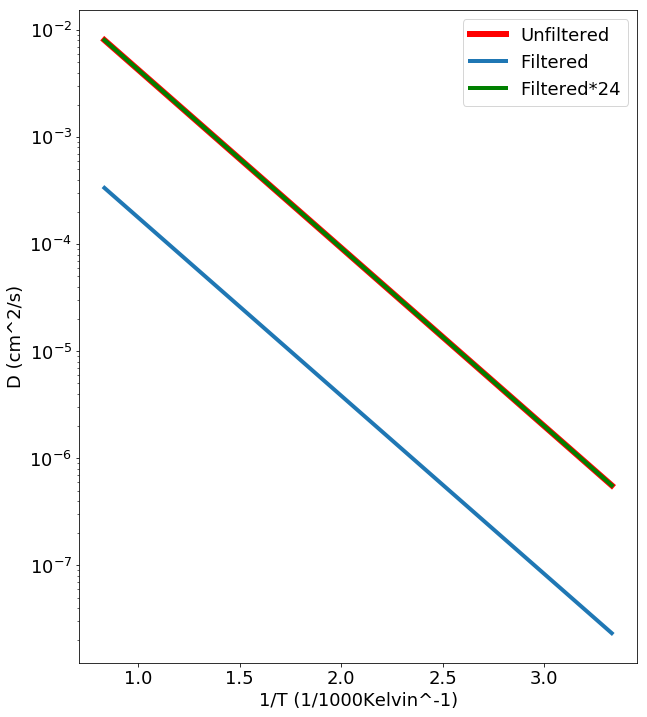

In [17]:
D = np.array(Dlist)
Dmin = np.array(Dminlist)
plt.figure(figsize=(10,12))
plt.semilogy(1/Trange*1000,D,"r",label="Unfiltered",linewidth=6.0)
plt.semilogy(1/Trange*1000,Dmin,label="Filtered",linewidth=4.0)
plt.semilogy(1/Trange*1000,Dmin*24,"g",label="Filtered*24",linewidth=4.0)
plt.xlabel("1/T (1/1000Kelvin^-1)",fontsize=18)
plt.ylabel("D (cm^2/s)",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.savefig("D vs invT.png",bbox_inches = 'tight')

In [15]:
print(D)

[5.59444261e-07 8.44476801e-07 1.24234350e-06 1.78539706e-06
 2.51167612e-06 3.46515159e-06 4.69587442e-06 6.26002239e-06
 8.21984733e-06 1.06435271e-05 1.36049296e-05 1.71832974e-05
 2.14628630e-05 2.65324073e-05 3.24847698e-05 3.94163246e-05
 4.74264310e-05 5.66168697e-05 6.70912740e-05 7.89545635e-05
 9.23123882e-05 1.07270590e-04 1.23934683e-04 1.42409367e-04
 1.62798061e-04 1.85202473e-04 2.09722209e-04 2.36454406e-04
 2.65493409e-04 2.96930479e-04 3.30853534e-04 3.67346931e-04
 4.06491275e-04 4.48363255e-04 4.93035524e-04 5.40576592e-04
 5.91050751e-04 6.44518031e-04 7.01034165e-04 7.60650590e-04
 8.23414453e-04 8.89368642e-04 9.58551836e-04 1.03099856e-03
 1.10673924e-03 1.18580033e-03 1.26820436e-03 1.35397004e-03
 1.44311238e-03 1.53564281e-03 1.63156927e-03 1.73089635e-03
 1.83362541e-03 1.93975470e-03 2.04927949e-03 2.16219219e-03
 2.27848248e-03 2.39813747e-03 2.52114174e-03 2.64747758e-03
 2.77712501e-03 2.91006195e-03 3.04626435e-03 3.18570626e-03
 3.32835999e-03 3.474196

In [18]:
print(Dmin*24)

[5.59444261e-07 8.44476801e-07 1.24234350e-06 1.78539706e-06
 2.51167612e-06 3.46515159e-06 4.69587442e-06 6.26002239e-06
 8.21984733e-06 1.06435271e-05 1.36049296e-05 1.71832974e-05
 2.14628630e-05 2.65324073e-05 3.24847698e-05 3.94163246e-05
 4.74264310e-05 5.66168697e-05 6.70912740e-05 7.89545635e-05
 9.23123882e-05 1.07270590e-04 1.23934683e-04 1.42409367e-04
 1.62798061e-04 1.85202473e-04 2.09722209e-04 2.36454406e-04
 2.65493409e-04 2.96930479e-04 3.30853534e-04 3.67346931e-04
 4.06491275e-04 4.48363255e-04 4.93035524e-04 5.40576592e-04
 5.91050751e-04 6.44518031e-04 7.01034165e-04 7.60650590e-04
 8.23414453e-04 8.89368642e-04 9.58551836e-04 1.03099856e-03
 1.10673924e-03 1.18580033e-03 1.26820436e-03 1.35397004e-03
 1.44311238e-03 1.53564281e-03 1.63156927e-03 1.73089635e-03
 1.83362541e-03 1.93975470e-03 2.04927949e-03 2.16219219e-03
 2.27848248e-03 2.39813747e-03 2.52114174e-03 2.64747758e-03
 2.77712501e-03 2.91006195e-03 3.04626435e-03 3.18570626e-03
 3.32835999e-03 3.474196